# HW1~3: 91APP之EDA

In [30]:
#call magic function
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import chartify
import matplotlib.dates as mdates
from matplotlib import axes
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import math

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

## Q1:讀取91APP其order的資料，將顧客按照消費特性分群

In [31]:
order = pd.read_csv('91APP/NTU_大數據與商業分析Datasets/Orders.csv')
order.head()

D:\anaconda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DateId,MemberId,OrderGroupCode,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,SalesOrderSlaveId,SalePageId,IsMajor,IsGift,...,SalesOrderReceiverId,City,District,ZipCode,StoreName,StoreId,DeliverTypeDef,StatusDef,ReturnGoodsDateId,CauseDef
0,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457777,1242871,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
1,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457778,1242880,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
2,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457779,1242880,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
3,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,Web,Mobile,SevenEleven,4457780,1175574,True,False,...,1480890,嘉義縣,水上鄉,608.0,中庄門市,910828,SevenEleven,Finish,NaN,NaN
4,20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",Web,Mobile,SevenEleven,4457791,1194488,True,False,...,1480896,桃園市,中壢區,320.0,復華門市,114071,SevenEleven,Finish,NaN,NaN


計算所有顧客在2015~2018年的購買次數

In [32]:
temp=order[["MemberId","SalesOrderSlaveTotalPayment"]].copy()
temp["Freqency"]=[1 for i in range(len(order))]
member_payment=temp.groupby("MemberId",as_index = False).sum().copy()
member_payment.head()

,MemberId,SalesOrderSlaveTotalPayment,Freqency
0,1326,249.0,1
1,1329,918.0,3
2,1334,999.0,3
3,1336,12473.0,5
4,1362,591.0,4


計算購買次數的中位數、平均、百分位數等...

In [33]:
member_payment["Freqency"].describe()

count    563457.000000
mean          9.752787
std          15.895283
min           1.000000
25%           3.000000
50%           5.000000
75%          11.000000
max        3628.000000
Name: Freqency, dtype: float64

將顧客分群有兩種方式，第一種是按照總消費金額的百分位數分成四類；第二種是按照消費次數的多寡按照平均次數等指標分成三類。
然而，假設有一位顧客花了1000元購買一次物品和另一位顧客花了500元購買2次物品，其總花費金額都是1000元，然而消費兩次的顧客代表相對第一位顧客更願意使用91APP做消費，因此應該給予相對的權重加權以表示顧客的忠實程度，因此給予新的指標payment_frq來評估對於顧客的重視程度(總消費金額*頻率開根號)，並按照此指標分群。

In [34]:
#new["SalesOrderSlaveTotalPayment"].quantile(0.01*i)
#https://blog.csdn.net/genome_denovo/article/details/78322628
cats = pd.qcut(member_payment["SalesOrderSlaveTotalPayment"],[0, .8,.95,.99,1.],labels=["small_pay","medium_pay","big_pay","top_pay"]) 
dogs = pd.cut(member_payment["Freqency"],[0,10,100,4000],labels=["low_frq","medium_frq","high_frq"]) 
member_payment["rank_payment"] = cats
member_payment["rank_frequency"] = dogs
member_payment["payment_frq"]=member_payment["SalesOrderSlaveTotalPayment"].multiply(member_payment["Freqency"]**0.5) 
member_payment.head()

,MemberId,SalesOrderSlaveTotalPayment,Freqency,rank_payment,rank_frequency,payment_frq
0,1326,249.0,1,small_pay,low_frq,249.000000
1,1329,918.0,3,small_pay,low_frq,1590.022641
2,1334,999.0,3,small_pay,low_frq,1730.318757
3,1336,12473.0,5,big_pay,low_frq,27890.475883
4,1362,591.0,4,small_pay,low_frq,1182.000000


單純分別按照總消費金額分類和消費次數分類的各族群數量多寡

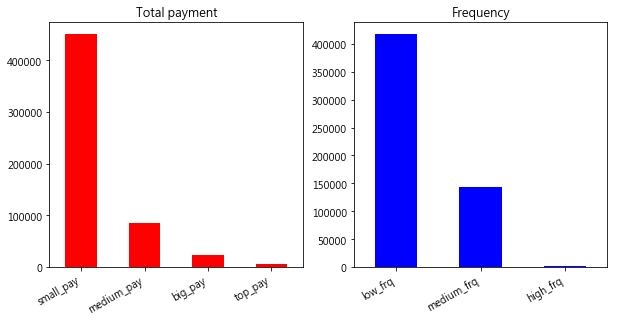

In [35]:
plt.figure(figsize=(10,5))
number_payment=member_payment["rank_payment"].value_counts()
number_frequency=member_payment["rank_frequency"].value_counts()
plt.subplot(1,2,1)
number_payment.plot(kind='bar', stacked=False,color='r')
plt.title('Total payment')
plt.subplot(1,2,2)
number_frequency.plot(kind='bar', stacked=True, color='b')
plt.title('Frequency')
plt.gcf().autofmt_xdate()
plt.show()

分析總消費金額和消費次數的關聯性，大致呈正比，但在總消費金額非常大的時候並不是，代表有些顧客是購買金額非常龐大但是購買次數很少。

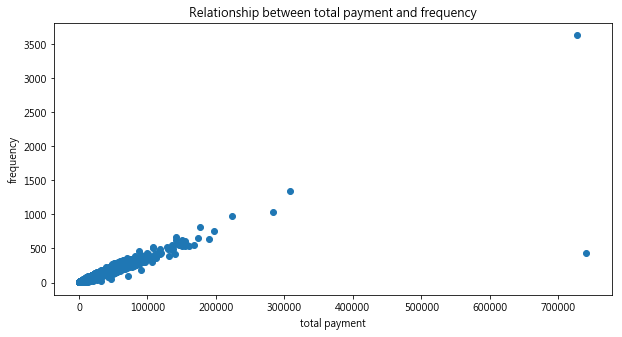

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(member_payment["SalesOrderSlaveTotalPayment"],member_payment["Freqency"])
plt.title('Relationship between total payment and frequency')
plt.xlabel("total payment")
plt.ylabel("frequency")
plt.show()


In [37]:
pff=(member_payment[["rank_payment","rank_frequency","payment_frq"]]
.groupby(["rank_payment","rank_frequency"],as_index = False).sum().copy() )
pff.head()

,rank_payment,rank_frequency,payment_frq
0,small_pay,low_frq,1.008277e+09
1,small_pay,medium_frq,3.177445e+08
2,small_pay,high_frq,NaN
3,medium_pay,low_frq,3.305380e+07
4,medium_pay,medium_frq,1.684638e+09


由此圖可發現按照消費總金額之分群和按照消費次數之分群之間的關聯性，我取出關聯性最大的四類當成顧客的分類依據

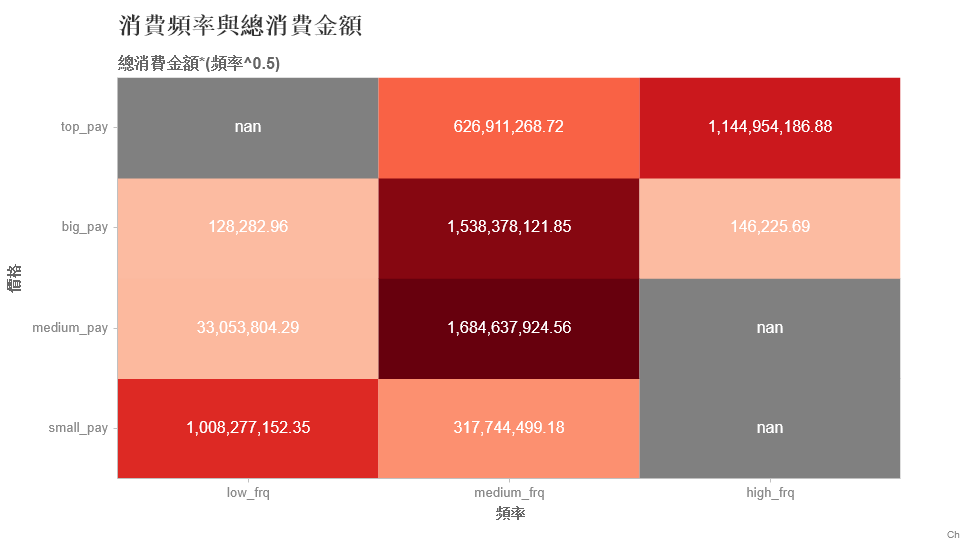

In [38]:
ch = chartify.Chart(
    x_axis_type='categorical', 
    y_axis_type='categorical')

ch.plot.heatmap(
    data_frame=pff, 
    y_column='rank_payment', 
    x_column='rank_frequency', 
    color_column='payment_frq', 
    text_column='payment_frq', 
    color_palette='Reds', )

ch.set_title("消費頻率與總消費金額")
ch.set_subtitle('總消費金額*(頻率^0.5)')
ch.set_source_label('Chartify')
ch.axes.set_xaxis_label('頻率')
ch.axes.set_yaxis_label('價格')

ch.show('png')

將顧客分成"白金、金、銀、銅"四類

In [40]:
few= member_payment["rank_frequency"]=="low_frq"  
more= member_payment["rank_frequency"]=="medium_frq"  
large= member_payment["rank_frequency"]=="high_frq"
small= member_payment["rank_payment"]=="small_pay" 
medium= member_payment["rank_payment"]=="medium_pay" 
big= member_payment["rank_payment"]=="big_pay" 
top= member_payment["rank_payment"]=="top_pay" 

temp3=order[["MemberId","City"]].copy()
temp3=temp3.drop_duplicates()
member_payment=pd.merge(member_payment,temp3)

final=member_payment[(few & small) | (more & medium) | (more & big) | (large & top)].copy()
final["Evaluation"]="NaN"
final["Evaluation"][(few & small)]="銅"
final["Evaluation"][(more & medium)]="銀"
final["Evaluation"][ (more & big) ]="金"
final["Evaluation"][(large & top)]="白金"
final.head()
#https://ithelp.ithome.com.tw/articles/10185182

D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWi

,MemberId,SalesOrderSlaveTotalPayment,Freqency,rank_payment,rank_frequency,payment_frq,City,Evaluation
0,1326,249.0,1,small_pay,low_frq,249.000000,台北市,銅
1,1329,918.0,3,small_pay,low_frq,1590.022641,台北市,銅
2,1334,999.0,3,small_pay,low_frq,1730.318757,台北市,銅
3,1334,999.0,3,small_pay,low_frq,1730.318757,新北市,銅
5,1362,591.0,4,small_pay,low_frq,1182.000000,台北市,銅


探討顧客各分類的比例

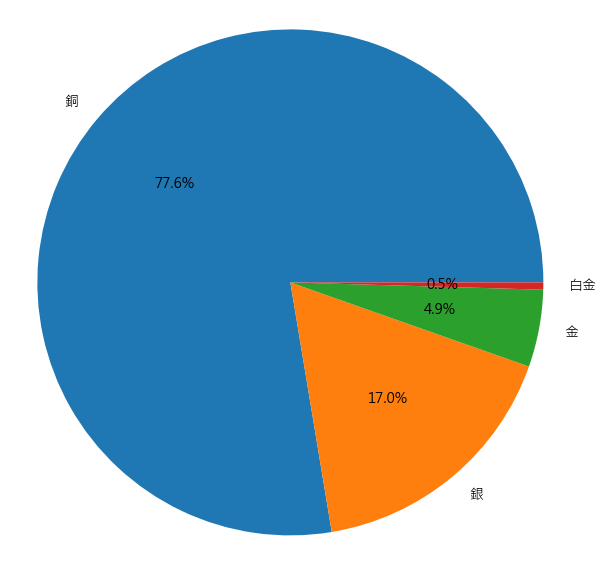

In [41]:
count_eva=pd.value_counts(final.Evaluation)
eva_name=list(count_eva.index)
eva_times=list(count_eva)
 
autopct='%1.1f%%' #是用來顯示百分比
plt.figure(figsize=(10,10))
plt.pie(eva_times,labels=eva_name,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.axis('equal')
plt.show()

## Q2:將顧客分類後，想探討各顧客分類在各縣市的比例

首先將order裡面city這一列的資料清理錯誤項，並畫圖顯示各縣市在order所佔的比例

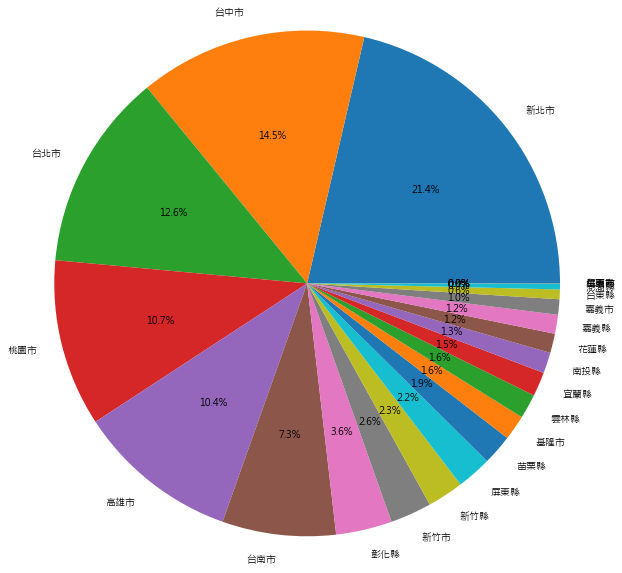

In [42]:
count_city=pd.value_counts(order.City)
city_name=list(count_city.index)
city_times=list(count_city)
for i in range(len(city_name)-1,22,-1):
    del(city_name[i])
    del(city_times[i])
    
autopct='%1.1f%%' #是用來顯示百分比
plt.figure(figsize=(10,10))
plt.pie(city_times,labels=city_name,autopct='%1.1f%%')
plt.axis('equal')
plt.show()


了解各類顧客在每一縣市的比例

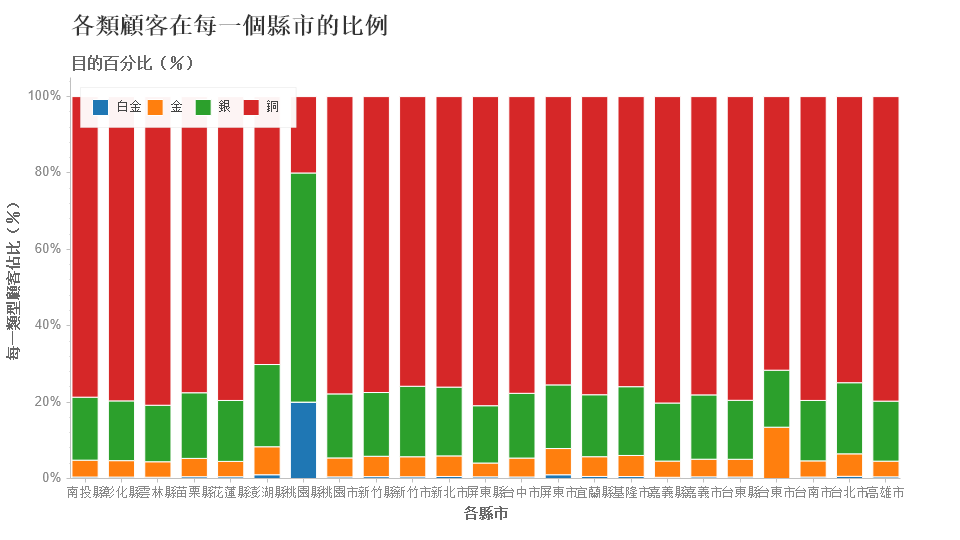

In [43]:
final = final.loc[final["City"].isin(city_name)]
temp4=final[["City","Evaluation"]].copy()
temp4["Freqency"]=[1 for i in range(len(final))]
city_eva=temp4.groupby(["City","Evaluation"],as_index = False).sum().copy()

ch = chartify.Chart(
    blank_labels=True,
    x_axis_type='categorical')

ch.plot.bar_stacked(
    data_frame=city_eva, 
    categorical_columns='City', 
    stack_column='Evaluation', 
    numeric_column='Freqency', 
    normalize=True)
#ch.set_legend_location('outside_bottom')
(ch.set_title('各類顧客在每一個縣市的比例')
 .set_subtitle('目的百分比（％）')
 .axes.set_xaxis_label('各縣市')
 .axes.set_yaxis_label('每一類型顧客佔比（％）')
 .show('png'))


了解每一個縣市佔各類型顧客的比例

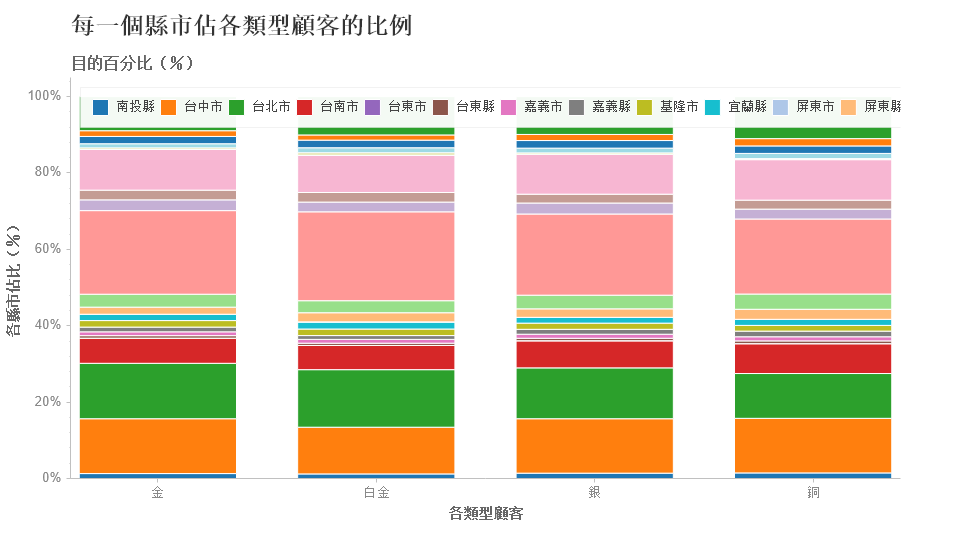

In [44]:
ch = chartify.Chart(
    blank_labels=True,
    x_axis_type='categorical'
)

ch.plot.bar_stacked(
    data_frame=city_eva, 
    categorical_columns='Evaluation', 
    stack_column='City', 
    numeric_column='Freqency', 
    normalize=True)

(ch.set_title('每一個縣市佔各類型顧客的比例')
 .set_subtitle('目的百分比（％）')
 .axes.set_xaxis_label('各類型顧客')
 .axes.set_yaxis_label('各縣市佔比（％）')
 .show('png'))

<font size="5">Q3:想知道在不同時間營業額的變化</font><br /> 

In [45]:
temp5=order[["DateId","SalesOrderSlaveTotalPayment"]].copy()
day_payment=temp5.groupby("DateId",as_index = False).sum().copy()
#date_payment.head()
day_payment["DateId"] = [datetime.strptime(str(x),'%Y%m%d') for x in day_payment["DateId"]]
day_payment.head()

,DateId,SalesOrderSlaveTotalPayment
0,2015-05-06,5999.0
1,2015-05-07,8547.0
2,2015-05-08,14664.0
3,2015-05-09,20439.0
4,2015-05-10,22902.0


從圖表可知似乎一年內每一天的總收益變化是有節奏的變化，但看不太出來波動的情形。此外，最高收益是在2016年11月11日。

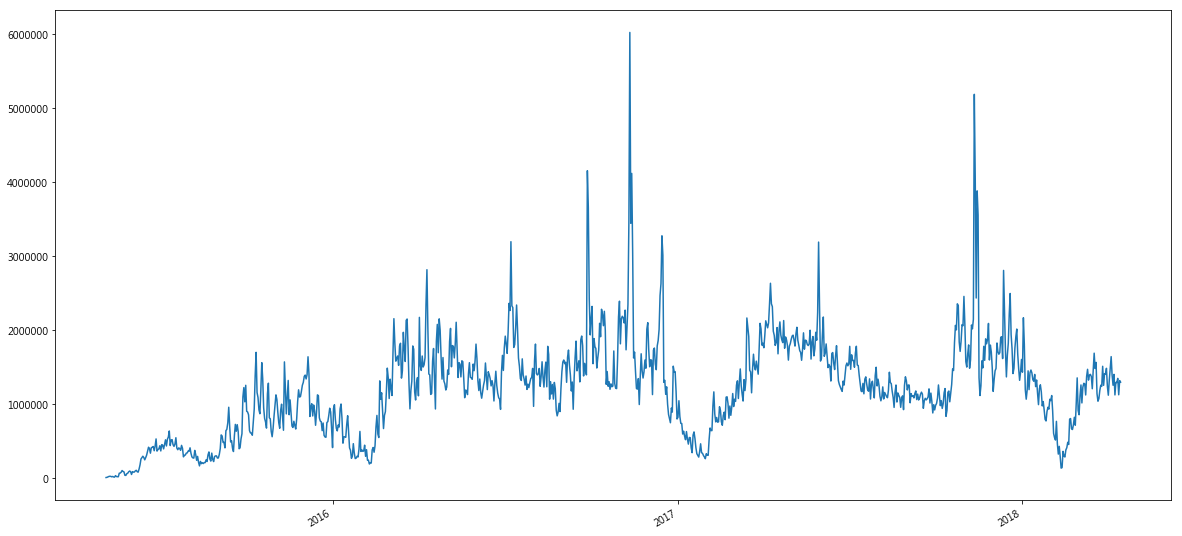

D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


NameError: name 'date_payment' is not defined

In [46]:
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.plot(day_payment["DateId"], day_payment["SalesOrderSlaveTotalPayment"])
plt.gcf().autofmt_xdate()  #自動旋轉日期標記
plt.show()
print ("The maximum total payment : \n",day_payment.ix[date_payment["SalesOrderSlaveTotalPayment"].idxmax()])

因此，我將每日的總收益轉成每月的總收益再來比較看看。

In [47]:
month_payment=day_payment.copy()
month_payment["DateId"] = [datetime.strptime(x.strftime('%Y%m'),'%Y%m') for x in day_payment["DateId"]]
month_payment.rename(columns={'DateId':'MonthId'}, inplace = True)
month_payment=month_payment.groupby("MonthId",as_index = False).sum()
month_payment.head()

,MonthId,SalesOrderSlaveTotalPayment
0,2015-05-01,1088629.0
1,2015-06-01,7806371.0
2,2015-07-01,13328028.0
3,2015-08-01,8427733.0
4,2015-09-01,17764823.0


觀察2015~2017三年內每月總收益變化可以知道在11月分最高、1月份最低。因此，以下將針對變化幅度最大之2016年11月和1月之間的時間做分析。

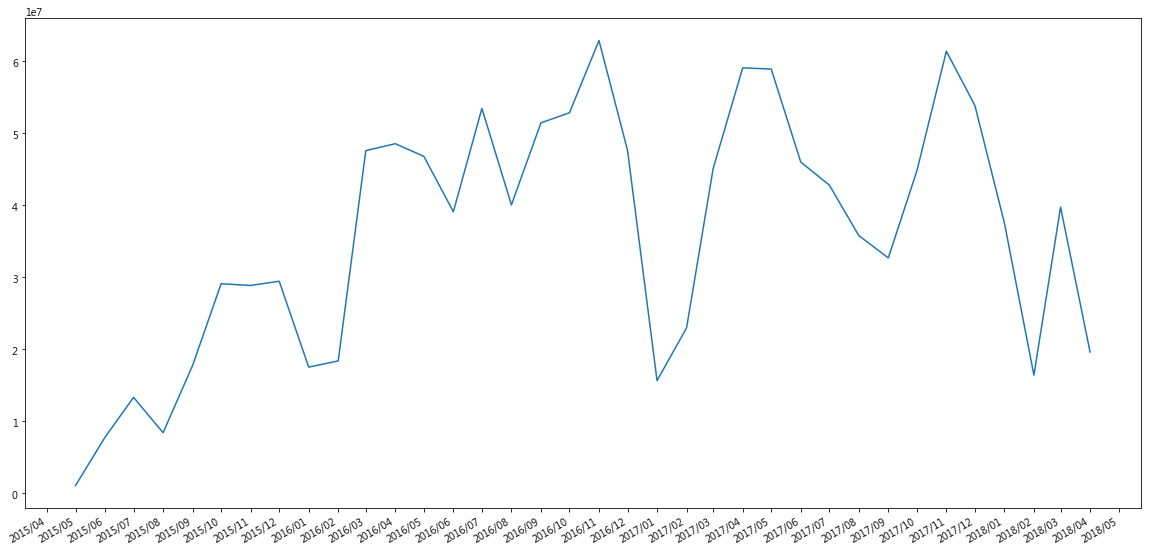

The maximum total payment : 
 MonthId                        2016-11-01 00:00:00
SalesOrderSlaveTotalPayment            6.28621e+07
Name: 18, dtype: object


D:\anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [48]:
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.plot(month_payment["MonthId"], month_payment["SalesOrderSlaveTotalPayment"])
plt.gcf().autofmt_xdate()  #自動旋轉日期標記
plt.show()
print ("The maximum total payment : \n",month_payment.ix[month_payment["SalesOrderSlaveTotalPayment"].idxmax()])

In [49]:

temp6=order[["DateId","SalesOrderSlaveTotalPayment","City"]].copy()
ele_city=temp6.groupby(["DateId","City"],as_index = False).sum().copy()
ele_city=ele_city[ (ele_city["DateId"]<20170201) & (ele_city["DateId"]>20161031)]
ele_city["DateId"] = [datetime.strptime(str(x),'%Y%m%d') for x in ele_city["DateId"]]
ele_city = ele_city.loc[ele_city["City"].isin(city_name)]
ele_city.head()



,DateId,City,SalesOrderSlaveTotalPayment
10690,2016-11-01,南投縣,30270.0
10691,2016-11-01,台中市,273980.0
10692,2016-11-01,台北市,252559.0
10693,2016-11-01,台南市,100181.0
10694,2016-11-01,台東市,749.0


可以發現營業額在11/15日左右為最高峰，推測是光棍節有促銷，而接近寒假大幅減少可能是因為接近過年大家要包紅包等雜事使得消費力道降低

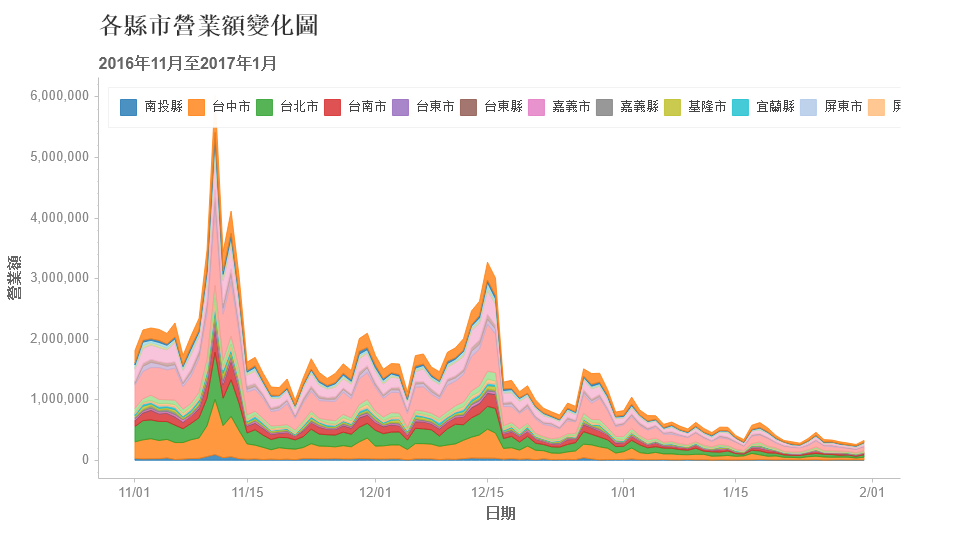

In [50]:
ch = chartify.Chart(
    x_axis_type='datetime')

ch.plot.area(
    data_frame=ele_city, 
    x_column='DateId', 
    y_column='SalesOrderSlaveTotalPayment', 
    color_column='City', 
    stacked=True)

ch.set_title('各縣市營業額變化圖')
ch.set_subtitle('2016年11月至2017年1月 ')
ch.set_source_label('')
ch.axes.set_xaxis_label('日期')
ch.axes.set_yaxis_label('營業額')
ch.show('png')



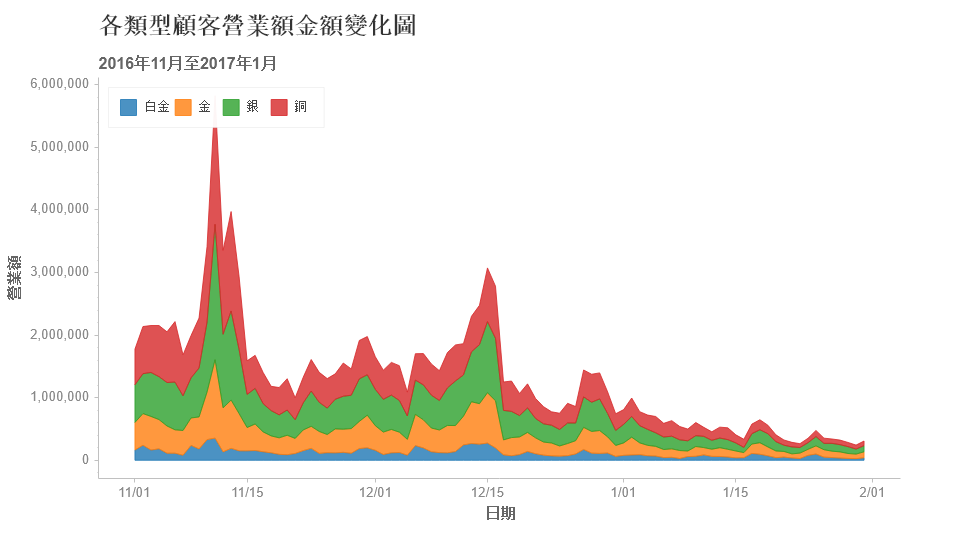

In [51]:
temp7=order[["DateId","MemberId","SalesOrderSlaveTotalPayment"]].copy()

ele_mem=temp7.groupby(["DateId","MemberId"],as_index = False).sum().copy()

temp8=final[["MemberId","Evaluation"]] 

yy = ele_mem.loc[ele_mem["MemberId"].isin(temp8["MemberId"])]
yy=yy[ (yy["DateId"]<20170201) & (yy["DateId"]>20161031)]
yy["DateId"] = [datetime.strptime(str(x),'%Y%m%d') for x in yy["DateId"]]

temp9=pd.merge(yy,temp8, on='MemberId')
eva=temp9.groupby(["DateId","Evaluation"],as_index = False).sum().copy()

ch = chartify.Chart(
    x_axis_type='datetime')

ch.plot.area(
    data_frame=eva, 
    x_column='DateId', 
    y_column='SalesOrderSlaveTotalPayment', 
    color_column='Evaluation', 
    stacked=True)

ch.set_title('各類型顧客營業額金額變化圖')
ch.set_subtitle('2016年11月至2017年1月 ')
ch.set_source_label('')
ch.axes.set_xaxis_label('日期')
ch.axes.set_yaxis_label('營業額')
ch.show('png')